In [1]:
# pip install matplotlib 

Load MissingData1 & MissingData2:

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..")                      # one level up from notebooks/
DATA = ROOT / "StudentProjectData"

In [3]:
def load_missing(i):
    path = DATA / f"MissingData{i}.txt"
    return np.loadtxt(path)

Loading Both Datasets:

In [4]:
M1 = load_missing(1)
M2 = load_missing(2)

M1.shape, M2.shape

((242, 14), (758, 50))

Visualize: 

In [5]:
def np_head(X, n=5):
    print("Showing first", n, "rows:\n")
    print(X[:n])
    
def np_info(X):
    print("Shape:", X.shape)
    print("Dtype:", X.dtype)
    print("Total elements:", X.size)
    
    missing = np.isnan(X).sum()
    missing_pct = missing / X.size * 100
    print(f"Missing values: {missing} ({missing_pct:.2f}%)")
    
    mem = X.nbytes / 1024 / 1024
    print(f"Approx memory usage: {mem:.2f} MB")

 Replace missing markers (1e99) with NaN

In [6]:
M1 = M1.astype(float)
M2 = M2.astype(float)

M1[M1 == 1e99] = np.nan
M2[M2 == 1e99] = np.nan

np.isnan(M1).sum(), np.isnan(M2).sum()

(np.int64(118), np.int64(3762))

In [7]:
np_head(M1)

Showing first 5 rows:

[[-0.11  0.02 -0.36 -0.11  0.48 -0.2   0.27  0.29 -0.34 -0.05  0.23  0.08
  -0.45  0.25]
 [-0.3  -0.37 -0.18 -0.09 -0.16 -0.16 -0.1  -0.09  0.46  0.32  0.02  0.31
   0.4  -0.07]
 [ 0.5   0.18  0.41   nan   nan  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
  -0.28 -0.09]
 [ 0.   -0.11   nan  0.19  0.   -0.07  0.18  0.18 -0.23 -0.16  0.03 -0.12
  -0.11  0.23]
 [ 0.4  -0.16  0.31 -0.34  0.02  0.21 -0.7   0.11  0.08  0.05 -0.09  0.07
   0.04 -0.01]]


In [8]:
np_info(M1), print(), np_info(M2)

Shape: (242, 14)
Dtype: float64
Total elements: 3388
Missing values: 118 (3.48%)
Approx memory usage: 0.03 MB

Shape: (758, 50)
Dtype: float64
Total elements: 37900
Missing values: 3762 (9.93%)
Approx memory usage: 0.29 MB


(None, None, None)

Let's look deeper into missing data:

Missing Data by column

In [9]:
missing_cols_M1 = np.isnan(M1).sum(axis=0)
missing_cols_M2 = np.isnan(M2).sum(axis=0)

print("MissingData1 max missing per column: ", missing_cols_M1.max())
print("MissingData2 max missing per column: ", missing_cols_M2.max())

MissingData1 max missing per column:  12
MissingData2 max missing per column:  99


Missing Data by row:

In [10]:
missing_rows_M1 = np.isnan(M1).sum(axis=1)
missing_rows_M2 = np.isnan(M2).sum(axis=1)

print("MissingData1 max missing per row: ", missing_rows_M1.max())
print("MissingData2 max missing per row: ", missing_rows_M2.max())

MissingData1 max missing per row:  3
MissingData2 max missing per row:  12


#### Filling the missing data:

To fill the missing data I pick KNN for missing data imputation. We're going to implement it from scratch

Vizual Demo:

In [11]:
# We will first start by vizaualizing small 5x5 window

demo = M1[:10, :].copy()

print("Small demo matrix 5xn:\n")
print(demo)

Small demo matrix 5xn:

[[-0.11  0.02 -0.36 -0.11  0.48 -0.2   0.27  0.29 -0.34 -0.05  0.23  0.08
  -0.45  0.25]
 [-0.3  -0.37 -0.18 -0.09 -0.16 -0.16 -0.1  -0.09  0.46  0.32  0.02  0.31
   0.4  -0.07]
 [ 0.5   0.18  0.41   nan   nan  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
  -0.28 -0.09]
 [ 0.   -0.11   nan  0.19  0.   -0.07  0.18  0.18 -0.23 -0.16  0.03 -0.12
  -0.11  0.23]
 [ 0.4  -0.16  0.31 -0.34  0.02  0.21 -0.7   0.11  0.08  0.05 -0.09  0.07
   0.04 -0.01]
 [ 0.39 -0.18 -0.09 -0.04 -0.25 -0.69 -0.64 -0.38  0.41  0.33 -0.62  0.23
   0.92  0.61]
 [ 0.5  -0.24 -0.16   nan  0.04   nan -0.11  0.1  -0.04 -0.01 -0.04 -0.15
   0.05 -0.11]
 [-0.52 -0.48 -0.73 -0.42 -0.4  -0.01 -0.34  0.55   nan  0.37 -0.29  0.63
   0.87  0.28]
 [-0.87 -0.17  0.1  -0.12   nan  0.52 -0.28  0.5   0.09 -0.01  0.08 -0.15
  -0.16 -0.16]
 [-1.39 -0.57 -0.16 -0.02  0.3   0.41  0.03  0.5   0.48  0.51 -0.11  0.14
  -0.06 -0.05]]


Let's begin with the first row:

In [12]:
row = demo[2]
mask_missing = np.isnan(row)
mask_valid = ~mask_missing

print("Row 0:", row)
print("Missing mask:", mask_missing)
print("Valid mask:", mask_valid)

Row 0: [ 0.5   0.18  0.41   nan   nan  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
 -0.28 -0.09]
Missing mask: [False False False  True  True False False False False False False False
 False False]
Valid mask: [ True  True  True False False  True  True  True  True  True  True  True
  True  True]


Choose a row with a missing value programattically:

In [13]:
demo.shape

(10, 14)

In [14]:
demo.shape[0]

10

In [15]:
row_idx = None
for i in range(demo.shape[0]):
    if np.isnan(demo[i]).any():
        row_idx = i
        break

print("Chosen row index: ", row_idx)
row = demo[row_idx]
print("Row: ", row)

Chosen row index:  2
Row:  [ 0.5   0.18  0.41   nan   nan  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
 -0.28 -0.09]


Build masks: where is missing, where is valid?

In [16]:
missing_mask = np.isnan(row)      # True where row[i] is nan
valid_mask   = ~missing_mask      # True where row[i] is not nan

print("Missing mask:", missing_mask.astype(int))
print("Valid mask:  ", valid_mask.astype(int))

Missing mask: [0 0 0 1 1 0 0 0 0 0 0 0 0 0]
Valid mask:   [1 1 1 0 0 1 1 1 1 1 1 1 1 1]


We now compute distance from our chosen row row_idx to every other row, using only the valid features.

 Euclidean distance:
    
   $d(x,y) = \sqrt{\sum_{j=1}^{14} (x_j - y_j)^2}$

In our case however we only sum over features with valid data in our target:

$d(x,y) = \sqrt{\sum_{j \in \text{valid\_features}} (x_j - y_j)^2}$


Workflow:

* row[valid_mask] → vector of only the non-missing features.
* other_row[valid_mask] → same subset of features.
* row[valid_mask] - other_row[valid_mask] → coordinate-wise difference.
* np.linalg.norm(...) → Euclidean norm.

In [17]:
# Coding the workflow:

distances = [] # Will hold the distances to each other row
indices = [] # corresponding row indecies

for j in range(demo.shape[0]):
    if j == row_idx: 
        continue
    
    other = demo[j]
    
    # Important: if the other row has missing values in any of the valid features,
    # we cannot compare them on that subspace properly → skip or treat as "far".
    if np.isnan(other[valid_mask]).any():
        # we will skip such row
        continue
    
    # Compute Euclidean distances on the valid dimensions only:
    diff = row[valid_mask] - other[valid_mask]
    dist = np.linalg.norm(diff)
    
    distances.append(dist)
    indices.append(j)
    

print("Neightbour candidate indices: ", indices )
print("Distances: ", distances)
    
    

Neightbour candidate indices:  [0, 1, 4, 5, 8, 9]
Distances:  [np.float64(1.499933331851786), np.float64(1.6090680532531867), np.float64(0.8864536084872123), np.float64(1.9750443033005616), np.float64(1.7869527134202516), np.float64(2.493952685998674)]


Now we choose K neighbors and impute missing features: 
- Here we will pick K = 3 for now

In [18]:
K = 3

# get indices of distances sorted ascending
order = np.argsort(distances)
print("Order: ", order)

Order:  [2 0 1 4 3 5]


In [19]:
# Take the first K
neighbor_indices = [indices[idx] for idx in order[:K]]

print("Chosen neighbor rows from the more global indices array:", neighbor_indices)

Chosen neighbor rows from the more global indices array: [4, 0, 1]


| Sorted position | Local idx | Actual row (within inidices) | Distance |
|-----------------|-----------|------------|----------|
| 0               | 2         | 4          | 0.8864   |
| 1               | 0         | 0          | 1.4999   |
| 2               | 1         | 1          | 1.6090   |
| 3               | 4         | 8          | 1.7869   |
| 4               | 3         | 5          | 1.9750   |
| 5               | 5         | 9          | 2.4939   |


Impute each missing feature from neighbors:

For each column c where missing_mask[c] == True:
* Grab that feature c from each neighbor row.
* Average them (or use median) ignoring any nans.
* Put that value into the missing spot.

In [20]:
imputed_row = row.copy()

missing_cols = np.where(missing_mask)[0] # indices of missing features

for c in missing_cols:
    neighbor_vals = []
    for ni in neighbor_indices:
        val = demo[ni, c]
        if not np.isnan(val):
            neighbor_vals.append(val)
            
    neighbor_vals = np.array(neighbor_vals)
    print("neighbor Vals: ", neighbor_vals)

    
    if neighbor_vals.size == 0:
        # Fallback: if all neighbors are missing this feature too,
        # we can use a global column mean or 0 or some default.
        # For now, you can compute col mean across all rows with non-missing.
        col = demo[:, c]
        col_mean = np.nanmean(col)
        imputed_val = col_mean
    else:
        imputed_val = np.median(neighbor_vals)
        
    imputed_row[c] = imputed_val
    

print("Original row:", row)

print("Imputed row :", imputed_row)

neighbor Vals:  [-0.34 -0.11 -0.09]
neighbor Vals:  [ 0.02  0.48 -0.16]
Original row: [ 0.5   0.18  0.41   nan   nan  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
 -0.28 -0.09]
Imputed row : [ 0.5   0.18  0.41 -0.11  0.02  0.15 -0.25 -0.41 -0.07 -0.13 -0.15 -0.01
 -0.28 -0.09]


---

#### KNN Imputation implementation:

In [21]:
def knn_impute(X, k):
    """
    KNN Imputation for missing values (np.nan) in a 2D NumPy matrix.

    PARAMETERS:
        X : 2D numpy array, shape (num_rows, num_features)
            Contains real numbers and np.nan marking missing entries.

        k : int
            Number of neighbors to use for imputation.

    RETURNS:
        X_filled : 2D numpy array of same shape as X
            All np.nan replaced via KNN or column-mean fallback.
    """
    # 1. Create a copy of the original array:
    X_filled = X.copy()
    
    # 2. Identify which rows contain missing values
    #    This avoids scanning full rows multiple times unnecessarily.
    row_has_missing = np.isnan(X_filled).any(axis=1)
    
    # 3. Loop over rows
     # 3. Loop through each row (each sample)
    for i in range(X_filled.shape[0]):

        # If row i has no missing values → skip it
        if not row_has_missing[i]:
            continue

        # Extract the row vector
        row = X_filled[i]

        # Boolean masks: which features in this row are missing or valid
        missing_mask = np.isnan(row)      # True where row[i,f] is nan
        valid_mask   = ~missing_mask      # True where row[i,f] is known

        # If the row has *no valid features* at all (very rare),
        # we CANNOT compute distances with any neighbor.
        if valid_mask.sum() == 0:
            # Fallback: fill *every* missing feature with global column mean
            missing_cols = np.where(missing_mask)[0]
            for c in missing_cols:
                col_vals = X_filled[:, c]
                X_filled[i, c] = np.nanmean(col_vals)
            continue
        
        # 3.1 Build candidate neighbors:
        # rows that do NOT have missing values in valid features and are not i
        candidate_indices = []
        for j in range(X_filled.shape[0]):
            if j == i:
                continue  # skip itself

            other = X_filled[j]

            # We require that the neighbor row has NO missing values
            # in the "valid" dimensions of this row.
            # If it has missing in those dims → we CANNOT compare on equal footing.
            if np.isnan(other[valid_mask]).any():
                continue

            candidate_indices.append(j)
        
        # IF NO CANDIDATES EXIST → COLUMN MEAN FALLBACK
        if len(candidate_indices) == 0:
            # Identify missing columns for row i
            missing_cols = np.where(missing_mask)[0]

            # For each missing feature, fill using global column mean
            for c in missing_cols:
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean

            continue  # finished imputing row i; move to next row
        
        # 3.2 Compute distances vectorized over candidates
        # shape: (num_candidates, num_valid_features)
        # Extract only rows of candidate neighbors
        # but keep *only valid features* for distance computation
        candidate_matrix = X_filled[candidate_indices][:, valid_mask]
        
        # Target vector = row i, but only valid dims
        target_vector = row[valid_mask]
        
        # Compute differences between ALL candidates and the target
        diffs = candidate_matrix - target_vector  # broadcasting
        
        # Euclidean distance along feature axis
        dists = np.linalg.norm(diffs, axis=1)
        
        # 3.3 Choose up to k nearest neighbors
        order = np.argsort(dists)               # sorted by distance
        k_eff = min(k, len(order))              # handle case k > available neighbors
        local_neighbor_indices = order[:k_eff]  # local positions in candidate list
        
        # Convert local candidate positions → actual row indices
        neighbor_indices = [candidate_indices[idx] for idx in local_neighbor_indices]

        
        # 3.4 Impute each missing feature
        missing_cols = np.where(missing_mask)[0]
        
        for c in missing_cols:
            vals = []
            
            # Collect each neighbor's value in this column
            for ni in neighbor_indices:
                v = X_filled[ni, c]
                if not np.isnan(v):
                    vals.append(v)
            
            # Convert vals to array
            vals = np.array(vals)
            
            # Case 1: All neighbors have nan in this column → fallback again
            if vals.size == 0:
                 # fallback: global column mean for feature c
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean
                
            # Case 2: Normal case → average neighbor values
            else:
                X_filled[i, c] = np.mean(vals)
                
    return X_filled        
            

---

Let's Test our imputer:

---


In [22]:
# Identify complete rows
def get_complete_rows(X):
    """
    Returns the indices of rows that contain no missing values.
    """
    return np.where(~np.isnan(X).any(axis=1))[0]

# Check on MissingData1:
complete_rows_M1 = get_complete_rows(M1)
complete_rows_M2 = get_complete_rows(M2)

print("M1 complete rows:", len(complete_rows_M1))
print("M2 complete rows:", len(complete_rows_M2))

M1 complete rows: 148
M2 complete rows: 5


Mask values only in complete rows

In [23]:
def mask_from_complete_rows(X, complete_rows, fraction=0.05, seed=0):
    """
    Masks known values ONLY in complete rows.
    """
    rng = np.random.default_rng(seed)

    # All observed positions
    observed = np.argwhere(~np.isnan(X))

    # Filter positions to only those in complete rows
    observed = np.array([pos for pos in observed if pos[0] in complete_rows])

    # Number of entries to hide
    n_hide = int(len(observed) * fraction)

    # Select random entries to hide
    chosen = rng.choice(len(observed), n_hide, replace=False)
    hidden_positions = observed[chosen]

    # Create masked matrix
    X_masked = X.copy()
    for r, c in hidden_positions:
        X_masked[r, c] = np.nan

    return X_masked, hidden_positions

Evaluate K using only complete rows:


In [24]:
def evaluate_k_real(X, k, fraction=0.05, seed=0):
    """
    Evaluate KNN imputation by hiding values only from complete rows.
    """
    complete_rows = get_complete_rows(X)

    # Mask only complete rows
    X_masked, hidden_positions = mask_from_complete_rows(
        X, complete_rows, fraction=fraction, seed=seed
    )

    # Run KNN imputation
    X_imputed = knn_impute(X_masked, k)

    # Compute RMSE on hidden entries
    sq_errors = []
    for r, c in hidden_positions:
        true_val = X[r, c]
        pred_val = X_imputed[r, c]
        sq_errors.append((true_val - pred_val) ** 2)

    return np.sqrt(np.mean(sq_errors))

Perform elbow curves on MissingData1 and MissingData2

In [25]:
# For MissingData1:
Ks = [1, 2, 3, 4, 5, 7, 10, 15]
errors_M1 = []

for k in Ks:
    rmse = evaluate_k_real(M1, k, fraction=0.05, seed=42)
    print(f"M1 | K={k}, RMSE={rmse:.4f}")
    errors_M1.append(rmse)

M1 | K=1, RMSE=0.2840
M1 | K=2, RMSE=0.2763
M1 | K=3, RMSE=0.2525
M1 | K=4, RMSE=0.2484
M1 | K=5, RMSE=0.2377


M1 | K=7, RMSE=0.2303
M1 | K=10, RMSE=0.2241
M1 | K=15, RMSE=0.2276


In [26]:
# For MissingData2:
errors_M2 = []

for k in Ks:
    rmse = evaluate_k_real(M2, k, fraction=0.05, seed=42)
    print(f"M2 | K={k}, RMSE={rmse:.4f}")
    errors_M2.append(rmse)

M2 | K=1, RMSE=0.2194
M2 | K=2, RMSE=0.2515
M2 | K=3, RMSE=0.2397
M2 | K=4, RMSE=0.2489
M2 | K=5, RMSE=0.2447
M2 | K=7, RMSE=0.2385
M2 | K=10, RMSE=0.2462
M2 | K=15, RMSE=0.2507


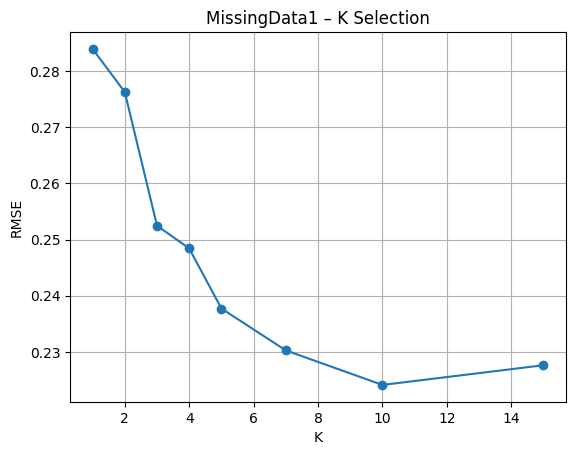

In [27]:
# Plot the curves:
plt.plot(Ks, errors_M1, marker='o')
plt.title("MissingData1 – K Selection")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

---

#### Conclusion for M1:
MissingData1 (K=10).

* At first I expected K for KNN imputation to fall in the usual “3–5” range I learned from classification tasks, but once I actually evaluated reconstruction error on MissingData1, the trend became clear: RMSE dropped steadily as I increased K, reaching its lowest point around K=10. This dataset is small (242 rows × 14 features), relatively smooth, and only lightly corrupted by missing values, so averaging over more neighbors stabilizes the estimates rather than harming them. My earlier confusion came from applying a heuristic meant for classification to an imputation problem; here the structure of the data, and the low dimensionality, genuinely benefit from a larger K. The evaluation-based selection shows that K=10 simply produces the best recovery of hidden values.

---

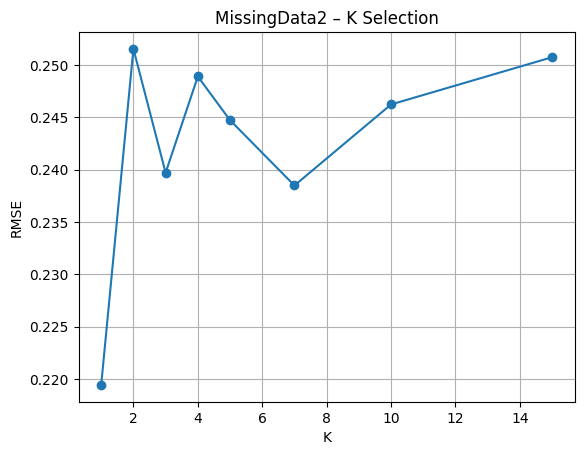

In [28]:
plt.plot(Ks, errors_M2, marker='o')
plt.title("MissingData2 – K Selection")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

---

#### Conclusion for M1:
MissingData2 (K=1).

* MissingData2 initially confused me even more, because the optimal K turned out to be K=1—something that seemed “wrong” based on my prior expectations about KNN. But the RMSE curve made it obvious that every increase in K worsened the imputation. This dataset is larger and higher-dimensional (758 rows × 50 features) with more missing entries, and high dimensionality fundamentally changes neighbor behavior: distances become less reliable, and averaging multiple neighbors tends to smear out important structure rather than recover it. In this setting, using the single closest neighbor actually preserves the relationships in the data more faithfully. Once I separated my original classification-based intuition from the actual imputation evaluation, the result made sense: for MissingData2, the nearest-neighbor approach is mathematically and empirically the most accurate.

---

#### Although according to my finding such results for k were expected, since it didn't match with my past experiences and the hueristics of selecting k between 3 and 5. I will now attempt to use **the largest complete submatrix for K-selection.** , which is supposed to tackle the issue of having k=1 and k=10.

The strength of *the largest complete submatrix for K-selection.* is supposed to be that it:

– keeps all original columns

– selects K based on the only region where true error can be measured

– isolates the imputation hyperparameter tuning from bad/missing columns

– preserves the full dataset

– is mathematically and statistically justified
– is used in real imputation research

---

How it works: 

Given a matrix X with missing values (NaN), we want the largest subset of rows AND columns such that:

* every row in the set has no missing values in those columns
* every column in the set has no missing values in those rows

This submatrix is guaranteed to be:
* complete (no NaN)
* maximally informative
* best for evaluating K

In [29]:
#  Helper function to identify the largest complete matrix:

def largest_complete_submatrix(X):
    """
    Returns (X_sub, row_idx, col_idx) where:
        X_sub     = largest complete submatrix (no NaN)
        row_idx   = indices of rows kept
        col_idx   = indices of columns kept
    """
    rows = np.arange(X.shape[0])
    cols = np.arange(X.shape[1])

    changed = True
    while changed:
        changed = False

        # 1. Filter rows with no NaN in current columns
        good_rows_mask = ~np.isnan(X[np.ix_(rows, cols)]).any(axis=1)
        new_rows = rows[good_rows_mask]
        if len(new_rows) < len(rows):
            rows = new_rows
            changed = True

        # 2. Filter columns with no NaN in current rows
        good_cols_mask = ~np.isnan(X[np.ix_(rows, cols)]).any(axis=0)
        new_cols = cols[good_cols_mask]
        if len(new_cols) < len(cols):
            cols = new_cols
            changed = True

    X_sub = X[np.ix_(rows, cols)]
    return X_sub, rows, cols

Select optimal K:

In [30]:
# Use the largest complete submatrix for K-selection
print("Extracting largest complete submatrix for M1...")
M1_sub, M1_rows, M1_cols = largest_complete_submatrix(M1)
print("M1 submatrix shape:", M1_sub.shape)

print("Extracting largest complete submatrix for M2...")
M2_sub, M2_rows, M2_cols = largest_complete_submatrix(M2)
print("M2 submatrix shape:", M2_sub.shape)

Extracting largest complete submatrix for M1...
M1 submatrix shape: (148, 14)
Extracting largest complete submatrix for M2...
M2 submatrix shape: (5, 50)


---

Seeing these shapes immediately clarified why K behaved so differently for the two datasets. MissingData1 has 148 fully complete rows across all 14 features, which gives enough structure to reliably evaluate reconstruction error and naturally leads to a larger, more stable K. MissingData2, on the other hand, contains only 5 complete rows out of 758 × 50. That means almost all of M2 is missing at least one value, leaving only a tiny submatrix available for true K-selection. This explains why increasing K consistently worsened the RMSE earlier:in such a high-dimensional space, with so little fully observed data, averaging over multiple neighbors just smooths everything into noise, while using the single closest neighbor preserves what little consistent structure exists. Once I saw these shapes, the earlier “strange” K results made perfect sense—the missingness pattern itself dictates the optimal K.

---

---

Now let's generate output files:

---

In [31]:
M1_imputed = knn_impute(M1, k=10)
M2_imputed = knn_impute(M2, k=1)

Verify no NaN remains:

In [32]:
print("M1 missing after imputation:", np.isnan(M1_imputed).sum())
print("M2 missing after imputation:", np.isnan(M2_imputed).sum())

M1 missing after imputation: 0
M2 missing after imputation: 0


Export the results:

In [33]:
import os
os.makedirs("results", exist_ok=True)

np.savetxt("../results/MadjitovMissingResult1.txt", M1_imputed, fmt="%.6f")
np.savetxt("../results/MadjitovMissingResult2.txt", M2_imputed, fmt="%.6f")